# CLSTM for Unsupervised Learning

## Data Preprocessing
### Including generation of Dyad-hours, sliding windows, and tokenization.

In [1]:
import numpy as np
import pandas as pd
import re
import h5py
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, MinMaxScaler
from sklearn.metrics import log_loss, auc, roc_curve
from lxml import etree
from itertools import groupby
import glob
import math
import itertools
from sklearn.metrics import *
import matplotlib.pyplot as plt

def load_xml_files(directory):
    """Load and parse XML files into a single DataFrame."""
    xml_list = glob.glob(f"{directory}/*.xml")
    parser = etree.XMLParser(recover=True)
    dfs = []

    for ii in xml_list:
        with open(ii, 'rb') as file:
            xml_data = file.read()
            root = etree.fromstring(xml_data, parser=parser)
            all_records = []
            for i, child in enumerate(root):
                record = {}
                for subchild in child:
                    record[subchild.tag] = subchild.text
                all_records.append(record)
            dfs.append(pd.DataFrame(all_records))
    
    data = pd.concat(dfs, ignore_index=True)
    return data.drop_duplicates().sort_values("startDateTime")

def preprocess_data(data):
    """Preprocess the data for sequence generation."""
    data['totalBytes'] = data['totalSourceBytes'].astype(float) + data['totalDestinationBytes'].astype(float)
    data['seqId'] = data['lowIP'] + '_' + data['highIP']  + '_' + data['startDateTime'].str[:13]
    data['protoBytes'] = data[['protocolName','totalBytes']].apply(
        lambda x: str(x[0])[0] + str(int(np.log2(x[1] + 1.0))), axis=1)
    return data

def create_sequences(data, seq_len=10):
    """Create input and output sequences from data."""
    key = data.groupby('seqId')[['Tag', 'protoBytes']].agg({
        "Tag": lambda x: "%s" % ','.join([a for a in x]),
        "protoBytes": lambda x: "%s" % ','.join([str(a) for a in x])
    })

    attacks = [a.split(",") for a in key['Tag'].tolist()]
    sequences = [a.split(",") for a in key['protoBytes'].tolist()]
    unique_tokens = list(set([a for b in sequences for a in b]))

    le = LabelEncoder()
    unique_tokens = list(set([a for b in sequences for a in b]))
    le.fit(unique_tokens)
    sequences = [le.transform(s).tolist() for s in sequences]
    sequences = [[b+1 for b in a] for a in sequences]

    sequence_attack = zip(attacks, sequences)

    seq_x = []
    seq_y = []
    seq_index = []
    seq_attack = []
    for si, (sa, ss) in enumerate(sequence_attack):
        prepend = [0.] * seq_len
        seq = prepend + ss
        seqa = prepend + sa
        for ii in range(seq_len, len(seq)):
            subseq = seq[(ii-seq_len):ii]
            seq_x.append(subseq)
            seq_y.append(seq[ii])
            seq_index.append(si)
            seq_attack.append(seqa[ii])

    return np.array(seq_x), np.array(seq_y), seq_index, seq_attack, unique_tokens

# Configuration and Initialization
data_directory = r"D:\AML\ISCX dataset\dirty"
print("Loading data...")
data = load_xml_files(data_directory)
print("Preprocessing data...")
data = preprocess_data(data)
print("Creating sequences...")
seq_x, seq_y, seq_index, seq_attack, unique_tokens = create_sequences(data)
ohe = OneHotEncoder(sparse=False)
ohe_y = ohe.fit_transform(np.array(seq_y).reshape(-1, 1))
X = np.array(seq_x)
print("Ready to go!")

Loading data...
De-dup Flows: 1889172


C:\Users\Yaphe\AppData\Local\Temp\ipykernel_21628\997353959.py:49: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  data['lowIP'] = data[['source','destination']].apply(lambda x: x[0] if x[0] <= x[1] else x[1], axis=1)
C:\Users\Yaphe\AppData\Local\Temp\ipykernel_21628\997353959.py:50: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  data['highIP'] = data[['source','destination']].apply(lambda x: x[0] if x[0] > x[1] else x[1], axis=1)
C:\Users\Yaphe\AppData\Local\Temp\ipykernel_21628\997353959.py:52: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be 

Ready to Go!


## Definition of the CLSTM Model
### We also utilized Convolutional LSTM (CLSTM) networks, which incorporate convolutional layers within the LSTM architecture, which consists of: The embedding layer converting input tokens into 100-dimensional vectors, with a padding index set at 0. Two 1D convolutional layers, each with 100 filters, a kernel size of 3, stride of 1, and padding of 1, designed to extract spatial features from the data. Two LSTM layers with 100 inputs and 50 hidden units each, processing data in both forward and backward directions to capture temporal dependencies. Dropout layers interspersed with a rate of 0.2 to prevent overfitting. And fully connected layers transforming LSTM outputs to the final output through two linear layers, reducing the features from 100 to 50, and then to 54 classes matching the vocabulary size.

In [2]:
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
import time

# Define the Dataset
class SequenceDataset(Dataset):
    def __init__(self, X, y):
        self.X = X
        self.y = y

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        x = torch.tensor(self.X[idx], dtype=torch.long)
        # Assuming y is already class indices here
        y = torch.tensor(self.y[idx], dtype=torch.long)  # Changed to long dtype
        return x, y

X_train, X_test, y_train, y_test = train_test_split(np.asarray(X), np.asarray(seq_y), test_size=0.2, random_state=42)
train_dataset = SequenceDataset(X_train, y_train)
test_dataset = SequenceDataset(X_test, y_test)

train_loader = DataLoader(train_dataset, batch_size=512, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=512, shuffle=False)  # Shuffle=False for testing


In [3]:
import torch
import torch.nn as nn

# Define the CLSTM Model
class CLSTM(nn.Module):
    def __init__(self, vocab_size, embedding_dim, hidden_dim, output_dim):
        super(CLSTM, self).__init__()
        self.embedding = nn.Embedding(vocab_size, embedding_dim, padding_idx=0)
        
        # Convolutional Layers
        self.conv1 = nn.Conv1d(embedding_dim, embedding_dim, kernel_size=3, padding=1)
        self.conv2 = nn.Conv1d(embedding_dim, embedding_dim, kernel_size=3, padding=1)
        
        self.lstm1 = nn.LSTM(embedding_dim, hidden_dim, batch_first=True, bidirectional=True)
        self.dropout1 = nn.Dropout(0.2)
        
        self.lstm2 = nn.LSTM(hidden_dim*2, hidden_dim, batch_first=True, bidirectional=True)
        self.dropout2 = nn.Dropout(0.2)
        
        self.fc1 = nn.Linear(hidden_dim*2, 50)
        self.dropout3 = nn.Dropout(0.2)
        self.fc2 = nn.Linear(50, output_dim)

    def forward(self, x):
        embedded = self.embedding(x)
        
        # Reshape for Conv1D input (batch_size, channels, seq_length)
        embedded = embedded.permute(0, 2, 1)
        
        # Apply convolutional layers with activation
        conv_out = torch.relu(self.conv1(embedded))
        conv_out = torch.relu(self.conv2(conv_out))
        
        # Reshape back to (batch_size, seq_length, channels)
        conv_out = conv_out.permute(0, 2, 1)
        
        lstm_out, _ = self.lstm1(conv_out)
        lstm_out = self.dropout1(lstm_out)
        
        lstm_out, _ = self.lstm2(lstm_out)
        lstm_out = self.dropout2(lstm_out[:, -1, :])  # Get the output of the last time step
        
        dense_out = torch.relu(self.fc1(lstm_out))
        dense_out = self.dropout3(dense_out)
        out = self.fc2(dense_out)  # No softmax here
        return out

# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Initialize model, loss, and optimizer
vocab_size = len(unique_tokens) + 1  # Account for padding index
model = CLSTM(vocab_size, 100, 50, vocab_size).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters())

## Architecture of CLSTM for Unsupervised Learning

In [4]:
print(model)

CLSTM(
  (embedding): Embedding(54, 100, padding_idx=0)
  (conv1): Conv1d(100, 100, kernel_size=(3,), stride=(1,), padding=(1,))
  (conv2): Conv1d(100, 100, kernel_size=(3,), stride=(1,), padding=(1,))
  (lstm1): LSTM(100, 50, batch_first=True, bidirectional=True)
  (dropout1): Dropout(p=0.2, inplace=False)
  (lstm2): LSTM(100, 50, batch_first=True, bidirectional=True)
  (dropout2): Dropout(p=0.2, inplace=False)
  (fc1): Linear(in_features=100, out_features=50, bias=True)
  (dropout3): Dropout(p=0.2, inplace=False)
  (fc2): Linear(in_features=50, out_features=54, bias=True)
)


## Training Process
### We utilized CrossEntropyLoss and Adam optimizer for adjusting network weights during training. The model is trained with learning rate of 1e-3, for 15 epochs.

In [5]:
import time
import matplotlib.pyplot as plt
import torch

# Lists to track loss and accuracy
train_losses = []
test_losses = []
train_accuracies = []
test_accuracies = []

epochs = 15
for epoch in range(epochs):
    epoch_start_time = time.time()
    model.train()
    running_loss = 0.0
    correct_predictions = 0
    total_predictions = 0

    for inputs, targets in train_loader:
        inputs = inputs.to(device)
        targets = targets.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, targets)
        running_loss += loss.item()
        loss.backward()
        optimizer.step()

        _, predicted = torch.max(outputs.data, 1)
        total_predictions += targets.size(0)
        correct_predictions += (predicted == targets).sum().item()

    # Average training loss and accuracy
    epoch_loss = running_loss / len(train_loader)
    epoch_accuracy = correct_predictions / total_predictions * 100
    train_losses.append(epoch_loss)
    train_accuracies.append(epoch_accuracy)

    # Evaluation
    model.eval()
    test_loss = 0.0
    correct_predictions = 0
    total_predictions = 0

    with torch.no_grad():
        for inputs, targets in test_loader:
            inputs = inputs.to(device)
            targets = targets.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, targets)
            test_loss += loss.item()

            _, predicted = torch.max(outputs.data, 1)
            total_predictions += targets.size(0)
            correct_predictions += (predicted == targets).sum().item()

    # Average test loss and accuracy
    test_epoch_loss = test_loss / len(test_loader)
    test_accuracy = correct_predictions / total_predictions * 100
    test_losses.append(test_epoch_loss)
    test_accuracies.append(test_accuracy)

    epoch_end_time = time.time()
    epoch_duration = epoch_end_time - epoch_start_time

    print(f"Epoch {epoch+1}/{epochs}, Loss: {epoch_loss:.4f}, Accuracy: {epoch_accuracy:.2f}%, "
          f"Test Loss: {test_epoch_loss:.4f}, Test Accuracy: {test_accuracy:.2f}%, "
          f"Duration: {epoch_duration:.2f} seconds")

Epoch 1/15, Loss: 1.6814, Accuracy: 45.59%, Test Loss: 1.5559, Test Accuracy: 48.36%, Duration: 40.15 seconds
Epoch 2/15, Loss: 1.5791, Accuracy: 47.99%, Test Loss: 1.5330, Test Accuracy: 48.92%, Duration: 38.35 seconds
Epoch 3/15, Loss: 1.5606, Accuracy: 48.53%, Test Loss: 1.5235, Test Accuracy: 49.17%, Duration: 37.51 seconds
Epoch 4/15, Loss: 1.5514, Accuracy: 48.81%, Test Loss: 1.5183, Test Accuracy: 49.30%, Duration: 72.33 seconds
Epoch 5/15, Loss: 1.5447, Accuracy: 48.98%, Test Loss: 1.5151, Test Accuracy: 49.37%, Duration: 86.95 seconds
Epoch 6/15, Loss: 1.5400, Accuracy: 49.07%, Test Loss: 1.5125, Test Accuracy: 49.40%, Duration: 76.47 seconds
Epoch 7/15, Loss: 1.5369, Accuracy: 49.17%, Test Loss: 1.5102, Test Accuracy: 49.53%, Duration: 90.49 seconds
Epoch 8/15, Loss: 1.5333, Accuracy: 49.26%, Test Loss: 1.5088, Test Accuracy: 49.61%, Duration: 95.60 seconds
Epoch 9/15, Loss: 1.5311, Accuracy: 49.33%, Test Loss: 1.5069, Test Accuracy: 49.69%, Duration: 95.26 seconds
Epoch 10/1

## Loss over Epochs Plot for Training Process

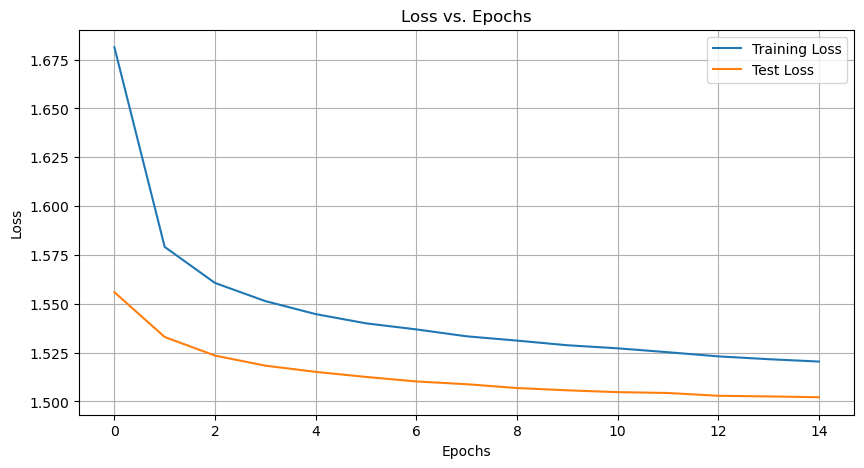

In [6]:
plt.figure(figsize=(10, 5))
plt.plot(train_losses, label='Training Loss')
plt.plot(test_losses, label='Test Loss')
plt.title('Loss vs. Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()

## Functions for Prediction

In [8]:
from torch.utils.data import DataLoader, TensorDataset

# Convert X to a PyTorch DataLoader
# ensure X is a tensor of the correct type. 
X_tensor = torch.tensor(X, dtype=torch.long)  # Convert X to a long tensor

data_loader = DataLoader(TensorDataset(X_tensor), batch_size=512)

predictions = []
model = model.to('cpu')
with torch.no_grad():
    for batch in data_loader:
        inputs = batch[0]
        outputs = model(inputs)
        predictions.extend(outputs.detach().numpy())


predictions = np.array(predictions)

# Apply softmax to represent probabilities
predictions = torch.softmax(torch.tensor(predictions), dim=1).numpy()


In [ ]:
test_index = range(0,len(predictions))
indexed_preds = zip(np.asarray(seq_index)[np.asarray(test_index)], predictions, ohe_y[np.asarray(test_index)], np.asarray(seq_attack)[np.asarray(test_index)])
logloss_list = []
epsilon = 1e-10
for (ii, pp, yy, aa) in indexed_preds:
    ll = -math.log(pp[np.argmax(yy)] + epsilon)
    logloss_list.append(ll)

fpr, tpr, thresholds = roc_curve(np.asarray(seq_attack)[np.asarray(test_index)],logloss_list, pos_label="Attack")

## ROC Curve for "Dirty" Dataset

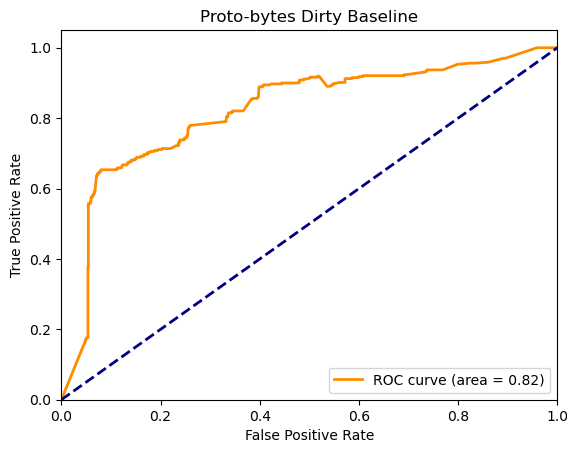

In [54]:
key_ll = zip(seq_index, logloss_list, seq_attack)
dictionary = dict()
for (key, ll, aa) in key_ll: #
    current_value = dictionary.get(str(key), ([],[]))
    dictionary[str(key)] = (current_value[0] + [ll], current_value[1] + [aa])

agg_ll = []
agg_bad = []
for key, val in dictionary.items():
    bad = str(np.mean([v=="Attack" for v in val[1]]) > 0.)
    score = np.max(val[0])
    agg_bad.append(bad)
    agg_ll.append(score)
    
fpr, tpr, thresholds = roc_curve(agg_bad, agg_ll, pos_label="True")

plt.figure()
lw = 2
plt.plot(fpr, tpr, color='darkorange',
         lw=lw, label='ROC curve (area = %0.2f)' % auc(fpr,tpr))
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Proto-bytes Dirty Baseline')
plt.legend(loc="lower right")
#plt.savefig("graphics/protobytes_dirty.pdf",format="pdf")
plt.show()

## ROC Curve for "NoDDOS" Dataset

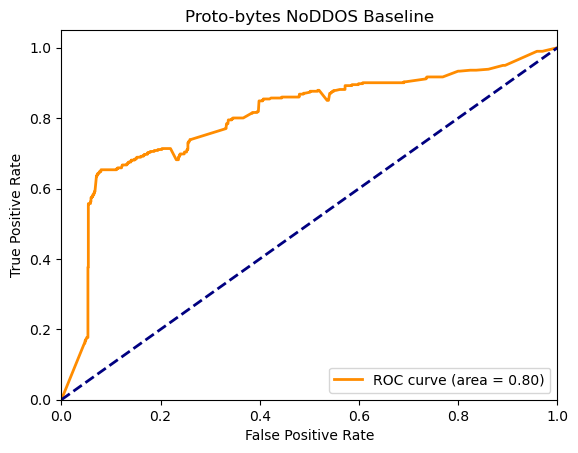

In [109]:
key_ll = zip(seq_index, logloss_list, seq_attack)
dictionary = dict()
for (key, ll, aa) in key_ll: #
    current_value = dictionary.get(str(key), ([],[]))
    dictionary[str(key)] = (current_value[0] + [ll], current_value[1] + [aa])

agg_ll = []
agg_bad = []
for key, val in dictionary.items():
    bad = str(np.mean([v=="Attack" for v in val[1]]) > 0.)
    score = np.max(val[0])
    agg_bad.append(bad)
    agg_ll.append(score)
    
fpr, tpr, thresholds = roc_curve(agg_bad, agg_ll, pos_label="True")

plt.figure()
lw = 2
plt.plot(fpr, tpr, color='darkorange',
         lw=lw, label='ROC curve (area = %0.2f)' % auc(fpr,tpr))
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Proto-bytes NoDDOS Baseline')
plt.legend(loc="lower right")
#plt.savefig("graphics/protobytes_dirty.pdf",format="pdf")
plt.show()

## ROC Curve for "Clean" Dataset

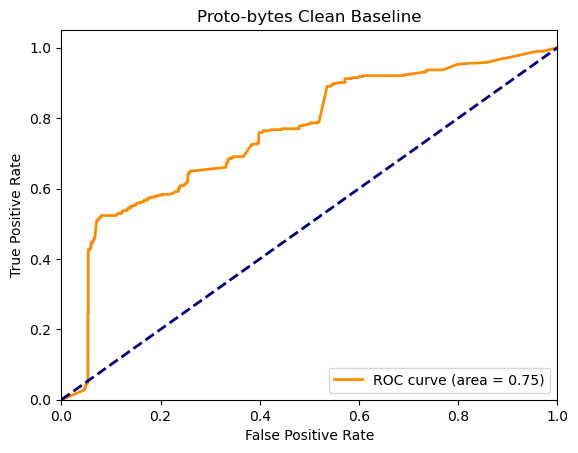

In [110]:
key_ll = zip(seq_index, logloss_list, seq_attack)
dictionary = dict()
for (key, ll, aa) in key_ll: #
    current_value = dictionary.get(str(key), ([],[]))
    dictionary[str(key)] = (current_value[0] + [ll], current_value[1] + [aa])

agg_ll = []
agg_bad = []
for key, val in dictionary.items():
    bad = str(np.mean([v=="Attack" for v in val[1]]) > 0.)
    score = np.max(val[0])
    agg_bad.append(bad)
    agg_ll.append(score)
    
fpr, tpr, thresholds = roc_curve(agg_bad, agg_ll, pos_label="True")

plt.figure()
lw = 2
plt.plot(fpr, tpr, color='darkorange',
         lw=lw, label='ROC curve (area = %0.2f)' % auc(fpr,tpr))
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Proto-bytes Clean Baseline')
plt.legend(loc="lower right")
#plt.savefig("graphics/protobytes_dirty.pdf",format="pdf")
plt.show()

## Performance Metrics (For "Dirty" Model, which is the best)

In [42]:
key_ll = zip(seq_index, logloss_list, seq_attack)
dictionary = dict()
for (key, ll, aa) in key_ll: #
    current_value = dictionary.get(str(key), ([],[]))
    dictionary[str(key)] = (current_value[0] + [ll], current_value[1] + [aa])

agg_ll = []
agg_bad = []
for key, val in dictionary.items():
    bad = str(np.mean([v=="Attack" for v in val[1]]) > 0.)
    score = np.max(val[0])
    agg_bad.append(bad)
    agg_ll.append(score)
    
fpr, tpr, thresholds = roc_curve(agg_bad, agg_ll, pos_label="True")

#! Find the true last token in the window
true_labels = np.argmax(ohe_y, 1)

#! Given the predictions and true labels, we can now aggregate the results
prob = [predictions[i, true_labels[i]] for i in range(len(ohe_y))]
agg_list = zip(seq_index, prob, seq_attack)
dictionary = {}
for (ii, pp, aa) in agg_list:
    current_value = dictionary.get(str(ii), ([],[]))
    dictionary[str(ii)] = (current_value[0] + [pp], current_value[1] + [aa])

#! Predict dyad hour data attack or not
agg_pred = []
agg_true = []

for key, val in dictionary.items():
    bad = np.mean([v=="Attack" for v in val[1]]) > 0
    score = np.min(val[0]) < 0.001
    agg_true.append(int(bad))
    agg_pred.append(int(score))

from sklearn.metrics import roc_curve, auc, precision_score, recall_score, f1_score, accuracy_score

# Assume the required data has been processed up to agg_pred and agg_true as shown above

# Calculating metrics
precision = precision_score(agg_true, agg_pred)
recall = recall_score(agg_true, agg_pred)
f1 = f1_score(agg_true, agg_pred)
accuracy = accuracy_score(agg_true, agg_pred)

print(f"Precision: {precision:.2f}")
print(f"Recall: {recall:.2f}")
print(f"F1 Score: {f1:.2f}")
print(f"Accuracy: {accuracy:.2f}")


# print("Prediction of Attack: ", agg_pred)
# print("True Label of Attack ", agg_true)  

Precision: 0.80
Recall: 0.75
F1 Score: 0.77
Accuracy: 0.89
